In [69]:
import numpy as np 
import matplotlib.pyplot as plt

import torch
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
from pytorch_lightning import Trainer

from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from pathlib import Path

from dataset import MushroomBodyDataset 
from rnn import NeuralRNNModule

import json
import pandas as pd

%load_ext autoreload
%aimport dataset, rnn
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
DATA_DIR = Path('../data')

X_train_file = DATA_DIR / 'X-train-exp-time-series-from-distribution.npy'
Y_train_file = DATA_DIR / 'Y-train-exp-time-series-from-distribution.npy'
train_dataset = MushroomBodyDataset(X_train_file, Y_train_file)
print(f'Train dataset size: {len(train_dataset)}')

X_val_file = DATA_DIR / 'X-val-exp-time-series-from-distribution.npy'
Y_val_file = DATA_DIR / 'Y-val-exp-time-series-from-distribution.npy'
val_dataset = MushroomBodyDataset(X_val_file, Y_val_file)
print(f'Val dataset size: {len(val_dataset)}')

X_test_file = DATA_DIR / 'X-test-exp-time-series-from-distribution.npy'
Y_test_file = DATA_DIR / 'Y-test-exp-time-series-from-distribution.npy'
test_dataset = MushroomBodyDataset(X_test_file, Y_test_file)
print(f'Test dataset size: {len(test_dataset)}')

Train dataset size: 18000
Val dataset size: 4500
Test dataset size: 4500


Datum shape for input and output is (timesteps, neurons): torch.Size([10, 15])


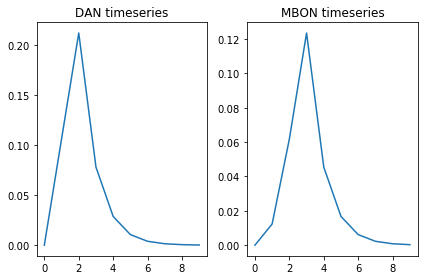

In [3]:
print(f'Datum shape for input and output is (timesteps, neurons): {train_dataset[0]["dan"].shape}')

fig, axs = plt.subplots(1,2)
axs[0].plot(train_dataset[0]["dan"][:,0])
axs[0].set_title('DAN timeseries')
axs[1].plot(train_dataset[0]["mbon"][:,0])
axs[1].set_title('MBON timeseries')
plt.tight_layout()
plt.show()

# Hyperparams

In [4]:
hparams = {
    'batch_size': 8,
    'lr': 0.00005,
    'non_linearity': 'tanh',
    'max_epochs': 20,
    'min_epochs': 1
}

# Create Dataloaders

In [5]:
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=hparams['batch_size'],
    shuffle=False, 
    num_workers=4
)

val_dataloader = DataLoader(
    val_dataset, 
    batch_size=hparams['batch_size'],
    shuffle=False, 
    num_workers=4
)

# Load Masks

In [6]:
import matplotlib.pyplot as plt

greek_lobes = [
    r"$\alpha'_1$", r"$\alpha'_2$", r"$\alpha'_3$", 
    r'$\alpha_1$', r'$\alpha_2$', r'$\alpha_3$', 
    r"$\beta'_1$", r"$\beta'_2$",
    r'$\beta_1$', r'$\beta_2$', 
    r'$\gamma_1$', r'$\gamma_2$', r'$\gamma_3$', r'$\gamma_4$', r'$\gamma_5$'
]

In [7]:
def plot_matrix(matrix, labels, title, cbar_title=None, size=[8,8], switch=False):
    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(matrix)


    plt.yticks(range(len(labels)), labels)
    plt.xticks(range(len(labels)), labels)
    plt.title(title)
    if switch:
        plt.xlabel('Target')
        plt.ylabel('Source')
    else:
        plt.xlabel('Source')
        plt.ylabel('Target')
    # Loop over data dimensions and create text annotations.
    for i in range(len(labels)):
        for j in range(len(labels)):
            col = 'white' if matrix[i, j] < matrix.max()/2 else 'black'
            text = ax.text(j, i, int(matrix[i, j]),
                           ha="center", va="center", color=col)

    # Create colorbar
    if cbar_title is not None:
        cbar = ax.figure.colorbar(im, ax=ax)
        cbar.ax.set_ylabel(cbar_title, rotation=-90, va="bottom")

    plt.tight_layout()
    plt.show()

In [8]:
mbon2mbon_connectome = np.load('../data/mbon-connectomics.npy')

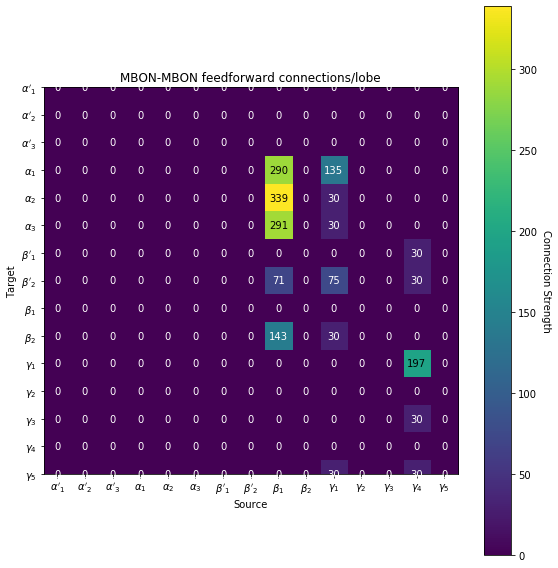

In [9]:
plot_matrix(
    mbon2mbon_connectome, 
    greek_lobes, 
    'MBON-MBON feedforward connections/lobe', 
    'Connection Strength'
)

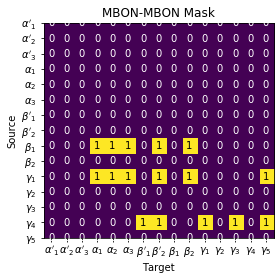

In [10]:
mbon_mask = torch.from_numpy((mbon2mbon_connectome > 0)*1.0)
plot_matrix(
    mbon_mask.t(), 
    greek_lobes, 
    'MBON-MBON Mask',
    size=[4,4],
    switch=True
)

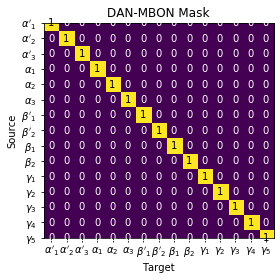

In [11]:
dan_mask = torch.from_numpy(np.diag(np.ones(15)))
plot_matrix(
    dan_mask.t(), 
    greek_lobes, 
    'DAN-MBON Mask',
    size=[4,4],
    switch=True
)

# Instantiate Model

In [12]:
model = NeuralRNNModule(
    masked=True,                           # if using masks for Wxh and Whh
    lr=hparams['lr'],                      # learning rate
    input_mask=dan_mask.t(),               # mask shape (in_dans, out_mbons) = (15,15)
    hidden_mask=mbon_mask.t(),             # mask shape (in_mbons, out_mbons) = (15,15)
    non_linearity=hparams['non_linearity'] # relu or tanh
)

model.hparams

"lr":            5e-05
"masked":        True
"non_linearity": tanh

In [13]:
# Check that the forward pass does what I expect
batch = next(iter(train_dataloader))
output = model(batch['dan'])
output.shape    # (batch, sequnce length, nodes)

torch.Size([8, 10, 15])

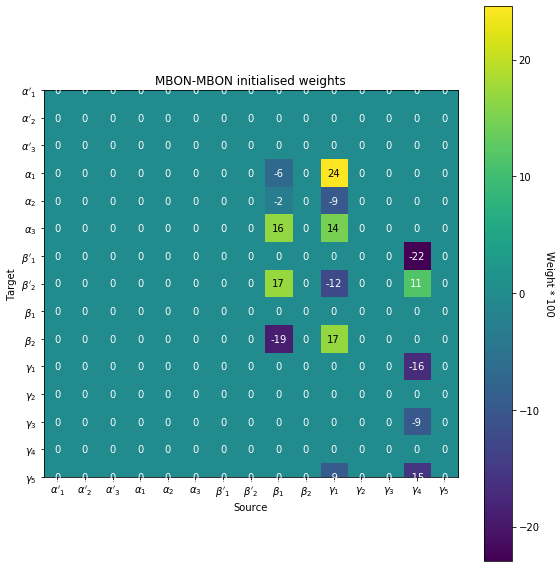

In [14]:
# Check the masked/unmasked weights before training
M = model.rnn.W_hh.weight.detach().numpy() * 100
plot_matrix(
    M, 
    greek_lobes, 
    'MBON-MBON initialised weights', 
    'Weight * 100',
    switch=False
)

# Train model

In [15]:
logger = TensorBoardLogger("tb_logs", name="masked_rnn", default_hp_metric=False)

In [16]:
logger.log_hyperparams(hparams)

In [17]:
trainer = Trainer(
    logger=logger,
    max_epochs=hparams['max_epochs'],
    min_epochs=hparams['min_epochs'],
    callbacks=[EarlyStopping(monitor='val/loss')]
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [18]:
trainer.fit(model, train_dataloader, val_dataloader)


  | Name     | Type            | Params
---------------------------------------------
0 | rnn      | MaskedNeuralRNN | 930   
1 | loss_fcn | MSELoss         | 0     
---------------------------------------------
480       Trainable params
450       Non-trainable params
930       Total params
0.004     Total estimated model params size (MB)


Epoch 0:  80%|███████▉  | 2250/2813 [00:30<00:07, 72.94it/s, loss=0.0158, v_num=13]
Validating: 0it [00:00, ?it/s]
Epoch 1:  80%|███████▉  | 2250/2813 [00:27<00:06, 81.76it/s, loss=0.0102, v_num=13] 
Validating: 0it [00:00, ?it/s]
Epoch 2:  80%|███████▉  | 2250/2813 [00:28<00:07, 79.97it/s, loss=0.00941, v_num=13]
Validating: 0it [00:00, ?it/s]
Epoch 3:  80%|███████▉  | 2250/2813 [00:27<00:07, 80.37it/s, loss=0.00882, v_num=13]
Validating: 0it [00:00, ?it/s]
Epoch 4:  80%|███████▉  | 2250/2813 [00:28<00:07, 79.00it/s, loss=0.00827, v_num=13]
Validating: 0it [00:00, ?it/s]
Epoch 5:  80%|███████▉  | 2250/2813 [00:28<00:07, 79.41it/s, loss=0.00781, v_num=13]
Validating: 0it [00:00, ?it/s]
Epoch 6:  80%|███████▉  | 2250/2813 [00:31<00:07, 70.41it/s, loss=0.00748, v_num=13]
Validating: 0it [00:00, ?it/s]
Epoch 7:  80%|███████▉  | 2250/2813 [00:28<00:07, 78.13it/s, loss=0.00724, v_num=13]
Validating: 0it [00:00, ?it/s]
Epoch 8:  80%|███████▉  | 2250/2813 [00:31<00:07, 72.56it/s, loss=0.00708

# Save model

In [19]:
MODEL_PATH = Path('../models/masked_rnn.pt')

torch.save(model.state_dict(), MODEL_PATH)

# Load model (optional)

In [53]:
# Load model for inference using:

MODEL_PATH = Path('../models/masked_rnn.pt')
model = NeuralRNNModule(
    masked=True,                           # if using masks for Wxh and Whh
    lr=hparams['lr'],                      # learning rate
    input_mask=dan_mask.t(),               # mask shape (in_dans, out_mbons) = (15,15)
    hidden_mask=mbon_mask.t(),             # mask shape (in_mbons, out_mbons) = (15,15)
    non_linearity=hparams['non_linearity'] # relu or tanh
)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

NeuralRNNModule(
  (rnn): MaskedNeuralRNN(
    (W_xh): CustomizedLinear(input_features=15, output_features=15, bias=True)
    (W_hh): CustomizedLinear(input_features=15, output_features=15, bias=True)
    (activation): Tanh()
  )
  (loss_fcn): MSELoss()
)

# Visualise the trained weights

In [20]:
def normalise(m):
    if m.min() < 0:
        return (m - m.min() )/ (m.max() - m.min())
    
    return m / m.max()

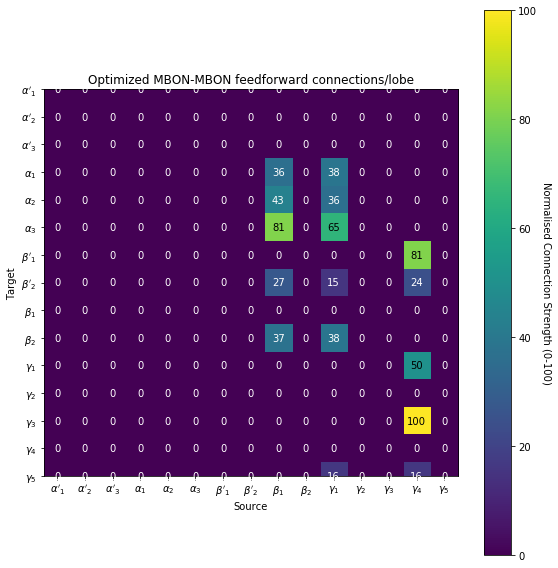

In [21]:
# multiply by 100 for visulisation purposes
M = normalise(model.rnn.W_hh.weight.detach().numpy()) * 100
plot_matrix(
    M, 
    greek_lobes, 
    'Optimized MBON-MBON feedforward connections/lobe', 
    'Normalised Connection Strength (0-100)'
)

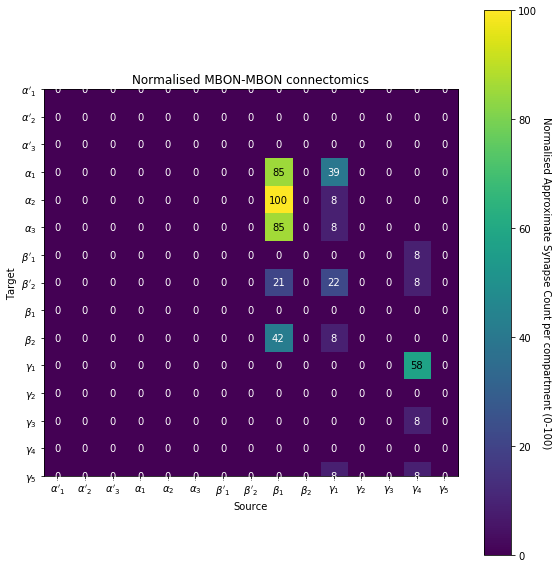

In [22]:
# multiply by 100 for visulisation purposes
M = normalise(mbon2mbon_connectome) * 100
plot_matrix(
    M, 
    greek_lobes, 
    'Normalised MBON-MBON connectomics', 
    'Normalised Approximate Synapse Count per compartment (0-100)'
)

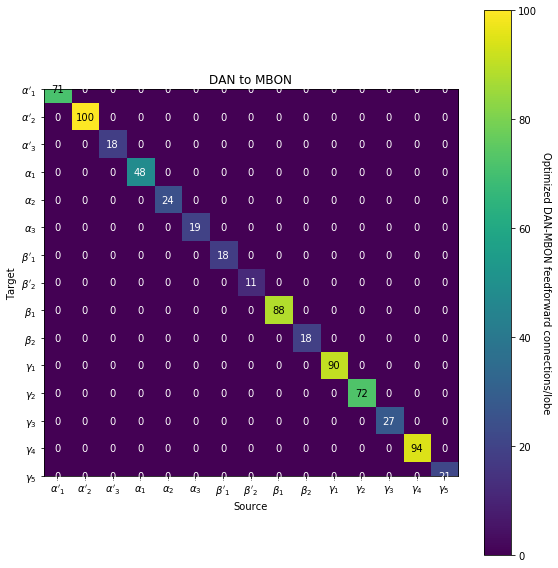

In [23]:
# multiply by 100 for visulisation purposes
M = normalise(model.rnn.W_xh.weight.detach().numpy()) * 100
plot_matrix(
    M, 
    greek_lobes, 
    'DAN to MBON', 
    'Optimized DAN-MBON feedforward connections/lobe'
)


# Inspect shape of the output

In [24]:
 model.eval()

NeuralRNNModule(
  (rnn): MaskedNeuralRNN(
    (W_xh): CustomizedLinear(input_features=15, output_features=15, bias=True)
    (W_hh): CustomizedLinear(input_features=15, output_features=15, bias=True)
    (activation): Tanh()
  )
  (loss_fcn): MSELoss()
)

In [25]:
test_dataloader = DataLoader(
    test_dataset, 
    batch_size=1,
    shuffle=False, 
    num_workers=4
)

batch = next(iter(val_dataloader))
output = model(batch['dan'])

print(output.shape)

torch.Size([8, 10, 15])


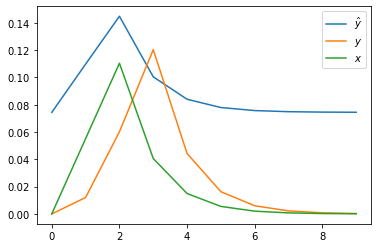

In [26]:
compartment = 11
plt.plot(output[0,:,compartment].detach().numpy(), label=r'$\hat y$')
plt.plot(batch['mbon'][0,:,compartment], label=r'$y$')
plt.plot(batch['dan'][0,:,compartment], label=r'$x$')

plt.legend()
plt.show()

# Testing

In [27]:
model.eval()

loss_fcn = nn.MSELoss()

test_dataloader = DataLoader(
    test_dataset, 
    batch_size=1,
    shuffle=False, 
    num_workers=4
)

In [28]:
gt = []
pred = []

test_loss = 0
for batch in test_dataloader:
    x = batch['dan']
    y = batch['mbon']
    y_pred = model(x)
    test_loss += loss_fcn(y, y_pred)

    gt.append(y.detach().numpy().squeeze())
    pred.append(y_pred.squeeze().detach().numpy())

av_test_loss = test_loss / len(test_dataloader)

In [33]:
av_test_loss.detach().numpy()

array(0.0055996, dtype=float32)

In [36]:
gt = np.array(gt)
pred = np.array(pred)

gt.shape

(4500, 10, 15)

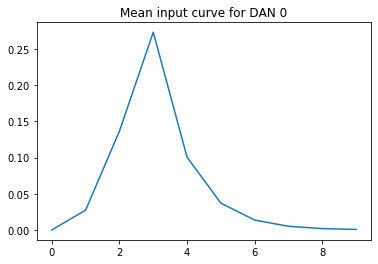

In [35]:
plt.plot(gt.mean(axis=0)[:,0])
plt.title('Mean input curve for DAN 0')
plt.show()

In [34]:
# calculate the r^2 for each output
# use this formula https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score
# 1 - (residual sum of squares) / (total sum of squares)

# total sum of squares: remove mean, square and sum
tss = np.sum((gt - gt.mean(axis=0))**2, axis=0)

# risidual sum of squares or the sum of residual errors
rss = np.sum((gt - pred)**2, axis =0)

rss.shape, tss.shape

((10, 15), (10, 15))

In [30]:
# above the shapes should be scalars.. so then
# how to do r squared on a time series?
# should I take the avearge of the output and compare that to the test set?

# tss/rss

# Average output and compare to sampled data directly

In [40]:
Y_test_file = DATA_DIR / 'Y-test-from-distribution.npy'
Y_test = np.load(Y_test_file)

(4500, 15)

In [41]:
mean_pred = pred.mean(axis=1)

Y_test.shape, mean_pred.shape

((4500, 15), (4500, 15))

In [48]:
mse = np.sum((Y_test - mean_pred) ** 2, axis = 0)/ Y_test.shape[0]

In [74]:
lobes = np.array(["alpha'1", "alpha'2", "alpha'3", 'alpha1', 'alpha2', 'alpha3',
       "beta'1", "beta'2", 'beta1', 'beta2', 'gamma1', 'gamma2', 'gamma3',
       'gamma4', 'gamma5'])

mse_rnn = {}

for i, lobe in enumerate(lobes):
    mse_rnn[lobe] = mse[i]

In [75]:
mse_rnn

{"alpha'1": 0.045435928772785385,
 "alpha'2": 0.1323410357383012,
 "alpha'3": 0.01854730209970928,
 'alpha1': 0.025026904724822902,
 'alpha2': 0.024385873575527583,
 'alpha3': 0.06950031581467066,
 "beta'1": 0.042906806918560754,
 "beta'2": 0.016699884336004465,
 'beta1': 0.043104853455033315,
 'beta2': 0.0219277413077706,
 'gamma1': 0.05742957348999731,
 'gamma2': 0.05564253147291933,
 'gamma3': 0.07212211187098956,
 'gamma4': 0.05303593407162479,
 'gamma5': 0.00627120275703157}

# Compare to linear models

In [76]:
RESULTS_DIR = Path('../results')

with open( RESULTS_DIR / 'canonical_linear_model_testing_data_mse.json', "r") as file:
    mse_canonical = json.load(file)

with open( RESULTS_DIR / 'crossed_linear_model_testing_data_mse.json', "r") as file:
    mse_crossed = json.load(file)
    
mse_df = pd.concat(
    [
        pd.Series(mse_canonical, name='canonical mse'), 
        pd.Series(mse_crossed, name='crossed mse'),
        pd.Series(mse_rnn, name='rnn mse') 
    ],
    axis=1
)


mse_df.describe()

,canonical mse,crossed mse,rnn mse
count,15.000000,15.000000,15.000000
mean,0.010724,0.009613,0.045625
std,0.011561,0.010431,0.031232
min,0.001789,0.001702,0.006271
25%,0.003226,0.003102,0.023157
50%,0.007856,0.006767,0.043105
75%,0.014011,0.012247,0.056536
max,0.046932,0.042517,0.132341
